In [72]:
from datetime import datetime as dt
import numpy as np
import torch

from matplotlib import pyplot as plt
from torch.utils.data import random_split

from preconditioners import settings
from preconditioners.datasets import generate_true_parameter, CenteredLinearGaussianDataset, generate_true_parameter, generate_c
from preconditioners.utils import MLP, SLP
from preconditioners.optimizers import PrecondGD
import preconditioners


In [73]:
# Same as in linear_kernel_variance_30102022.ipynb (and if it is not, it should be)

from preconditioners.datasets import generate_c, generate_centered_linear_gaussian_data, generate_true_parameter, generate_W_star

def kernel_variance_interpolator(features : np.ndarray, P : np.ndarray, F : np.ndarray, sigma2 : np.float64) -> np.float64:
    ''' Given Nxp feature matrix {features}, pxp symmetric preconditioner P and pxp true covariance matrix F, and the signal to noise ratio, this function returns the variance component of the risk 
    of the interpolator which is the limit of PGD which uses preconditioner P.'''
    assert features.shape[1] == P.shape[0] == P.shape[1] == F.shape[0] == F.shape[1]
    assert abs(P - P.T).mean() < 1e-4, 'P must be symmetric.'

    empirical_NTK = features.dot(P).dot(features.T)
    empirical_NTK_inv = np.linalg.inv(empirical_NTK)
    auxi_matrix = features.dot(P).dot(F).dot(P).dot(features.T)

    return sigma2 * np.trace(empirical_NTK_inv.dot(auxi_matrix).dot(empirical_NTK_inv))

In [74]:
# Adapted CheckEigenvalues class from src/preconditioners/eigenvalues/kernel_eigenvalues.py
# with the linear gaussian dataset

class Initializer:
    def __init__(self,
                width,
                depth,
                d,
                lam,
                train_size,
                extra_size,
                sigma2,
                r2,
                regime,
                ro,
                ):
        # Network parameters
        self.width = width
        self.depth = depth
        self.d = d
        self.damping = lam * np.sqrt(self.d) if self.depth == 1 else lam * self.width

        # Dataset parameters
        self.train_size = train_size
        self.extra_size = extra_size

        w_star = generate_true_parameter(self.d, r2, m=np.eye(self.d))
        c = generate_c(ro, regime=regime, d=self.d) if self.depth > 1 else generate_c(ro, regime=regime, d=self.d) * np.sqrt(self.d) # we don't need to multiply by sqrt(d) if d > 1 because there c is not the Fisher
        dataset = CenteredLinearGaussianDataset(w_star, c, n=self.train_size + self.extra_size, d=self.d, sigma2=sigma2)

        self.train_dataset, self.extra_dataset = random_split(dataset, [self.train_size, self.extra_size])
        self.labeled_data = self.train_dataset[:][0].double().to(settings.DEVICE)
        self.unlabeled_data = self.extra_dataset[:][0].double().to(settings.DEVICE)

    def create_model(self):
        std = 1/ np.sqrt(self.width)

        # Create model and optimizer
        if self.depth == 1:
            self.model = SLP(in_channels=self.d).double().to(settings.DEVICE)
        else:
            self.model = MLP(in_channels=self.d, num_layers=self.depth, hidden_channels=self.width, std=std).double().to(settings.DEVICE)
        self.optimizer = PrecondGD(self.model, lr=1e-2, labeled_data=self.labeled_data, unlabeled_data=self.unlabeled_data, verbose=False, damping=self.damping)

    def get_features_and_p_inv(self):
         self.create_model()
         p_inv = self.optimizer._compute_p_inv()
         grad = self.optimizer._compute_grad_of_data(self.labeled_data)
         return grad, p_inv

    def get_features_and_F(self):
        self.create_model()
        F = self.optimizer._compute_fisher()
        grad = self.optimizer._compute_grad_of_data(self.labeled_data)
        return grad, F

In [75]:
## Test that I get the same results if the MLP is a linear network.

N = 20
N_extra = 30000
sigma2 = 2
ro = 0.9
n_ds = 10
n_lams = 10
ds = [int(x) for x in np.linspace(2*N,65*N,n_ds)]
ams = np.linspace(0.1,10,n_lams)
lams = np.logspace(0, -3, num=n_lams, endpoint=True, base=10.0)

d = 100
lam = 0.1

# linear
np.random.seed(0)
damping = lam * np.sqrt(d)
c = np.sqrt(d) * generate_c(ro=ro, regime='autoregressive', d=d)
X = np.random.multivariate_normal(mean=np.zeros(d), cov=c, size=N)
#P_damped = np.linalg.inv(c + damping*np.eye(d))
P_ngd = np.linalg.inv(c)

# get it through the initializer
i = Initializer(width = 1,
                depth = 1,
                d = d,
                lam = lam,
                train_size = N,
                extra_size = N_extra,
                sigma2 = sigma2,
                r2 = 1,
                regime = 'autoregressive',
                ro = ro)

grad, F = i.get_features_and_F()
#grad, F_inv = i.get_features_and_p_inv()

print(abs(F-c).mean())
#print(np.linalg.norm(F_inv - P_damped)/np.sqrt(F_inv.shape[0]))

tensor(0.0440, dtype=torch.float64)


In [76]:
F[:3,:3]

tensor([[10.0165,  9.0078,  8.1416],
        [ 9.0078,  9.9632,  8.9948],
        [ 8.1416,  8.9948, 10.0032]], dtype=torch.float64)

In [77]:
c[:3,:3]

array([[10. ,  9. ,  8.1],
       [ 9. , 10. ,  9. ],
       [ 8.1,  9. , 10. ]])

In [78]:
############################################################################################################

# In the below, am I not changing the dimension of the data, instead of changing the dimension of the model?
# Fix it.

############################################################################################################

In [79]:
abs(P_ngd - P_ngd.T).mean()

1.721999263637377e-16

In [80]:
lams

array([1.        , 0.46415888, 0.21544347, 0.1       , 0.04641589,
       0.02154435, 0.01      , 0.00464159, 0.00215443, 0.001     ])

In [81]:
import matplotlib.pyplot as plt
import numpy as np

N = 10
N_extra = 30000
d = 15
sigma2 = 2
ro = 0.9
n_ns = 4
n_lams = 4
variances_damped = np.zeros((n_ns,n_lams))
variances_ngd = np.zeros((n_ns,n_lams))
variances_diff = np.zeros((n_ns,n_lams))    
largest_eigval_F_div_n = np.zeros((n_ns,n_lams))

ns = [int(x) for x in np.linspace(int(np.sqrt(1.5*N)),int(np.sqrt(6*N)),n_ns)]
ps = []
lams = np.logspace(0, -2, num=n_lams, endpoint=True, base=10.0)
dampings = []

k = 0
for i in range(n_ns):
    for j in range(n_lams):
        k = k+1
        print(f'iteration {k} of {n_ns*n_lams}')
        n = ns[i]
        lam = lams[j]
        damping = lam * n # TODO: check if multiplying by n is correct
        dampings.append(damping)
        
        params = {
            'width' : n,
            'depth' : 2,
            'd' : d,
            'lam' : lam, # damping does not matter here if we are not using .get_features_and_p_inv()
            'train_size' : N,
            'extra_size' : N_extra,
            'sigma2' : sigma2,
            'r2' : 1,
            'regime' : 'autoregressive',
            'ro' : ro
        }
        # TODO: think about what is happening to lambda
        ini = Initializer(**params)
        features, F_extra = [x.numpy() for x in ini.get_features_and_F()]
        p = F_extra.shape[0]
        print(p)
        ps.append(p)
        #P_ngd = np.linalg.inv(F_extra + 1e-7 * np.eye(p)) # adding a small number to avoid singular matrix
        P_ngd = np.linalg.inv(F_extra)
        P_damped = np.linalg.inv(F_extra + damping * np.eye(p))
        largest_eigval_F_div_n[i, j] = np.linalg.eigvalsh(F_extra)[-1]/n
        
        variances_damped[i, j] = kernel_variance_interpolator(features=features, P=P_damped, F=F_extra, sigma2=sigma2) 
        variances_ngd[i, j] = kernel_variance_interpolator(features=features, P=P_ngd, F=F_extra, sigma2=sigma2)
        variances_diff = variances_damped - variances_ngd

# choose only unique ps
ps = np.unique(ps)

iteration 1 of 16
51
iteration 2 of 16
51
iteration 3 of 16
51
iteration 4 of 16
51
iteration 5 of 16
68
iteration 6 of 16
68
iteration 7 of 16
68
iteration 8 of 16
68
iteration 9 of 16
85
iteration 10 of 16
85
iteration 11 of 16
85
iteration 12 of 16
85
iteration 13 of 16
119
iteration 14 of 16
119
iteration 15 of 16
119
iteration 16 of 16
119


In [82]:
ns

[3, 4, 5, 7]

In [83]:
P_ngd.shape

(119, 119)

In [84]:
abs(P_ngd - P_ngd.T).mean()

1.919624890077172e-06

In [85]:
lams

array([1.        , 0.21544347, 0.04641589, 0.01      ])

In [86]:
print(variances_diff[0,:])
print(variances_diff[-1,:])


[ 2.93138389 16.54621801  1.62855125  2.92883684]
[4.25162231 2.20376775 2.36819844 3.07939926]


In [87]:
print(variances_diff[:,0])
print(variances_diff[:,1])
print(variances_diff[:,2])

[2.93138389 3.24538369 2.06453211 4.25162231]
[16.54621801  2.15879027  2.04423382  2.20376775]
[1.62855125 1.5344186  2.34081939 2.36819844]


In [88]:
ps

array([ 51,  68,  85, 119])

<AxesSubplot: >

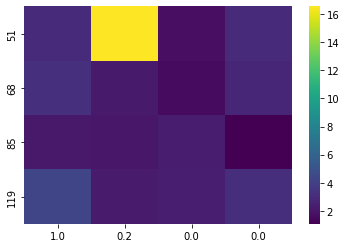

In [93]:
import seaborn as sns
sns.heatmap(variances_diff, cmap='viridis', xticklabels=[round(x, 1) for x in lams], yticklabels=np.unique(ps))

In [94]:
# divide each row of largest_eigval_F_div_n by the corresponding

In [95]:
largest_eigval_F_div_n

array([[0.31159753, 0.46564859, 0.79500419, 0.44552594],
       [0.51493574, 0.19639807, 0.25373017, 0.34891709],
       [0.43036858, 0.29826224, 0.29379363, 0.39070164],
       [0.11932392, 0.17504401, 0.22715187, 0.12866675]])

<AxesSubplot: >

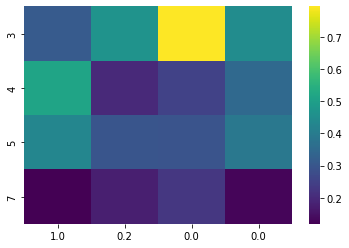

In [96]:
sns.heatmap(largest_eigval_F_div_n, cmap='viridis', xticklabels=[round(x, 1) for x in lams], yticklabels=ns)

In [11]:
#######################################################################################################
#######################################################################################################


In [61]:
# TODO: Triple check that we are computing the inverse well now and that we were doing it wrong before. Because the tests were passing before.

In [62]:
c[:3,:3]

array([[7.07106781, 6.36396103, 5.72756493],
       [6.36396103, 7.07106781, 6.36396103],
       [5.72756493, 6.36396103, 7.07106781]])

In [63]:
(c + damping*np.eye(d))[:3,:3]

array([[7.77817459, 6.36396103, 5.72756493],
       [6.36396103, 7.77817459, 6.36396103],
       [5.72756493, 6.36396103, 7.77817459]])

In [64]:
np.linalg.inv(c+ damping*np.eye(d))[:3,:3]

array([[ 0.40672876, -0.26077797, -0.06749992],
       [-0.26077797,  0.573929  , -0.21749976],
       [-0.06749992, -0.21749976,  0.58513116]])

In [18]:
import torch
torch.cholesky_inverse(torch.from_numpy(c+ damping*np.eye(d)))[:3,:3]

tensor([[ 0.0352, -0.0173, -0.0002],
        [-0.0173,  0.0352, -0.0173],
        [-0.0002, -0.0173,  0.0352]], dtype=torch.float64)

In [39]:
import torch
torch.cholesky_inverse(torch.cholesky(torch.from_numpy(c+ damping*np.eye(d))))[:3,:3]

tensor([[ 0.1522, -0.1304, -0.0057],
        [-0.1304,  0.2640, -0.1256],
        [-0.0057, -0.1256,  0.2642]], dtype=torch.float64)

In [40]:
np.linalg.inv(c+ damping*np.eye(d))[:3,:3]

array([[ 0.15224482, -0.13042363, -0.00565121],
       [-0.13042363,  0.26397487, -0.1255824 ],
       [-0.00565121, -0.1255824 ,  0.26418464]])

In [41]:
P_damped[:3,:3]

array([[ 0.15224482, -0.13042363, -0.00565121],
       [-0.13042363,  0.26397487, -0.1255824 ],
       [-0.00565121, -0.1255824 ,  0.26418464]])

In [42]:
F_inv.numpy()[:3,:3]

array([[ 1.73584905e-03, -8.49996340e-04, -8.67206609e-06],
       [-8.49996340e-04,  1.73288370e-03, -8.62042779e-04],
       [-8.67206609e-06, -8.62042779e-04,  1.76788253e-03]])